In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import cudf as gd
from cuml.manifold.umap import UMAP as cumlUMAP
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import FIGURE_DIR, ensure_dir
from avgn.utils.general import save_fig

In [5]:
DATASET_ID = 'buckeye'

In [6]:
window_loc = DATA_DIR / "umap_windows/buckeye/them_then_4.pickle"

In [7]:
words_df = pd.read_pickle(window_loc)

In [8]:
words_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
69,48.811535,48.956812,then,"[n, eh, n]","[0.0, 0.018174999999999386, 0.11372099999999818]","[0.018174999999999386, 0.11372099999999818, 0....",2,1,1,s25,0,o,f,s2501b,16000,"[[215, 211, 197, 169, 147, 154, 162, 153, 168,...","[[[215, 212, 80, 140, 187, 138, 127, 100, 121,..."
84,54.420270,54.759360,them,"[dh, eh, m]","[0.0, 0.06698699999999747, 0.23886999999999858]","[0.06698699999999747, 0.23886999999999858, 0.3...",18,5,5,s25,0,o,f,s2501b,16000,"[[27, 26, 21, 15, 6, 0, 0, 0, 1, 0, 2, 83, 162...","[[[27, 5, 6, 5, 8, 21, 32, 24, 30, 9, 1, 1, 1,..."
100,57.823111,58.016800,then,"[n, eh, n]","[0.0, 0.03323400000000021, 0.14072300000000126]","[0.03323400000000021, 0.14072300000000126, 0.1...",66,22,22,s25,0,o,f,s2501b,16000,"[[203, 229, 235, 230, 221, 219, 218, 219, 217,...","[[[203, 231, 194, 134, 47, 140, 119, 120, 98, ..."


In [120]:
words_df = words_df[np.array([i[0] != 'n' for i in words_df.phones])]

In [121]:
len(words_df)

1690

In [122]:
word_group = '_'.join(words_df.word.unique())
word_group

'them_then'

In [123]:
FIG_SAVE_LOC = FIGURE_DIR/'umap_seqs' / DATASET_ID / word_group
ensure_dir(FIG_SAVE_LOC)

In [124]:
pd.DataFrame({i:[sum(words_df.indv ==i)] for i in  words_df.indv.unique()})

,s25,s08,s24,s40,s15,s17,s13,s16,s26,s35,...,s01,s14,s28,s20,s29,s31,s39,s04,s33,s21
0,75,66,51,38,37,25,52,106,17,37,...,28,62,40,9,55,25,30,31,19,25


In [125]:
np.unique(np.concatenate(words_df.phones.values))

array(['aa', 'ae', 'ah', 'ahn', 'aw', 'b', 'd', 'dh', 'dx', 'eh', 'ehn',
       'em', 'en', 'ey', 'f', 'ih', 'iy', 'jh', 'm', 'n', 'ng', 'nx', 'p',
       's', 't', 'th', 'tq', 'uh', 'uhn', 'v', 'w', 'z'], dtype='<U3')

In [126]:
n_windows = [len(row.windows) for idx, row in words_df.iterrows()]
words = np.concatenate([np.repeat(row.word, len(row.windows)) for idx, row in words_df.iterrows()])

In [127]:
n_windows[:5]

[85, 27, 70, 99, 84]

In [128]:
# get beginnings and endings of each sequence
onsets = [0]
offsets = [n_windows[0]-1]
for wd in n_windows[1:]:
    onsets.append(offsets[-1]+1)
    offsets.append(onsets[-1]+wd-1)
onsets[:5], offsets[:5], len(onsets), len(offsets)

([0, 85, 112, 182, 281], [84, 111, 181, 280, 364], 1690, 1690)

In [129]:
{i:sum(words == i) for i in np.unique(words)}

{'them': 47246, 'then': 33661}

In [130]:
words[:10]

array(['them', 'them', 'them', 'them', 'them', 'them', 'them', 'them',
       'them', 'them'], dtype='<U4')

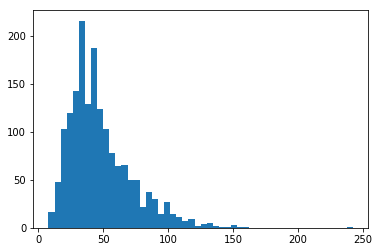

In [131]:
plt.hist(n_windows, bins=50);

In [132]:
rate = 16000

In [133]:
windows = np.vstack(list(words_df.windows))
print(np.shape(windows))
windows = np.reshape(windows, (len(windows), np.prod(np.shape(windows)[1:])))
print(np.shape(windows))

(80907, 1, 32)
(80907, 32)


In [134]:
cuml_umap = cumlUMAP()#min_dist = 0.25)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [135]:
embedding[embedding<-10] = -10
embedding[embedding>10] = 10

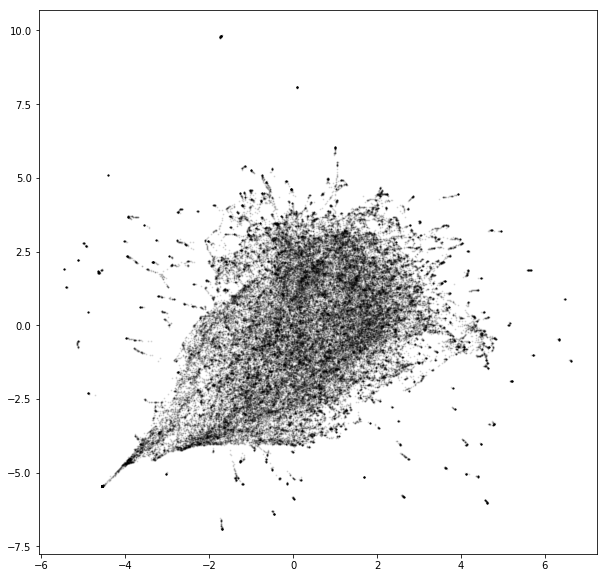

In [136]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.1, s = 1, color='k')

#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])

### plot over time

In [137]:
savefig = False

In [138]:
from avgn.visualization.projections import colorline

In [139]:
xlims = [-5,5]
ylims = [-6,6]

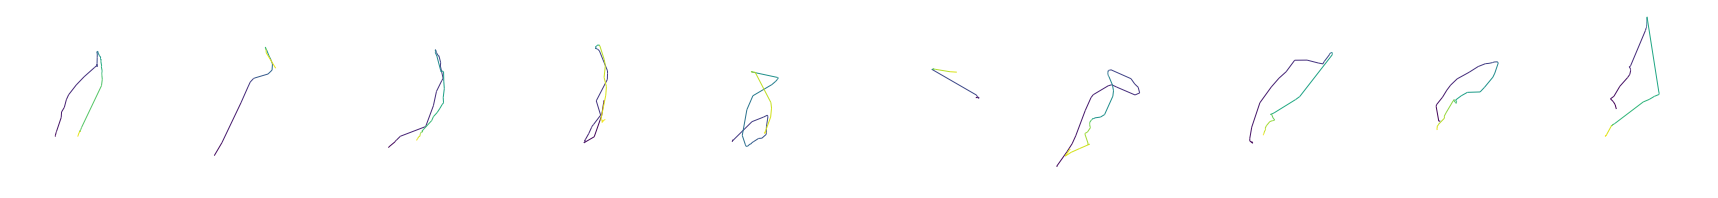

In [140]:
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)

fig, axs = plt.subplots(ncols = 10, figsize=(30,3))

for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    ax = axs[oi]
    window_z = embedding[on:off,:]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.1, s = 1, color=cols)
    colorline(window_z[:,0], window_z[:,1], alpha = 1, ax = ax, cmap=plt.cm.viridis, linewidth=1)
    
    ax.set_xlim(xlims);
    ax.set_ylim(ylims);
    ax.axis('off')
    if oi == 9:
        break
plt.show()


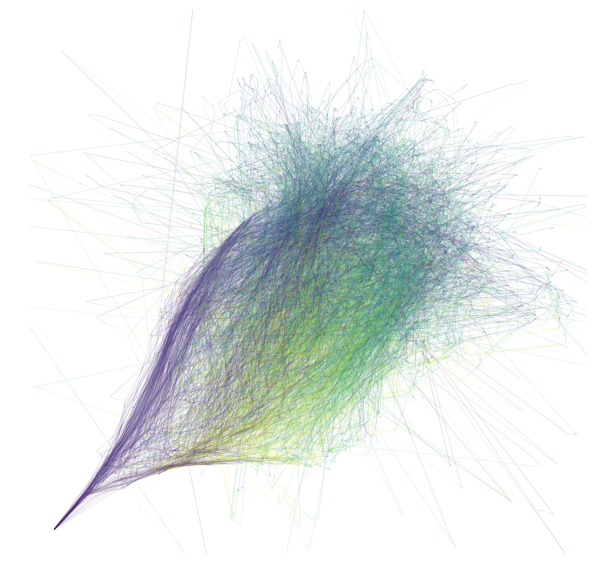

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)


for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.1, s = 1, color=cols)
    colorline(window_z[:,0], window_z[:,1], alpha = 0.1, ax = ax, cmap=plt.cm.viridis, linewidth=1)
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'trajectory', save_png=True)

### plot by word

In [142]:
len(np.unique(words))

2

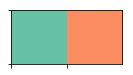

In [143]:
pal = sns.color_palette('Set2', len(np.unique(words)))
sns.palplot(pal)
word_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words))}

In [144]:
word_pal

{'them': (0.4, 0.7607843137254902, 0.6470588235294118),
 'then': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)}

In [145]:
cols = [word_pal[i] for i in words]

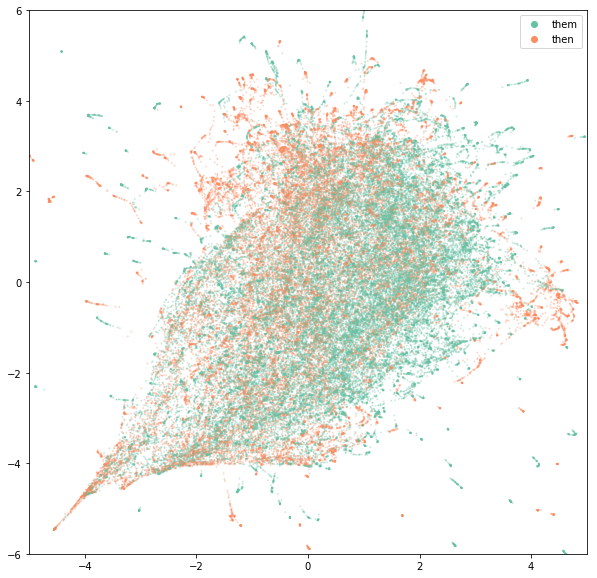

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.25, s = 1, color=cols)
ax.set_xlim(xlims);
ax.set_ylim(ylims);

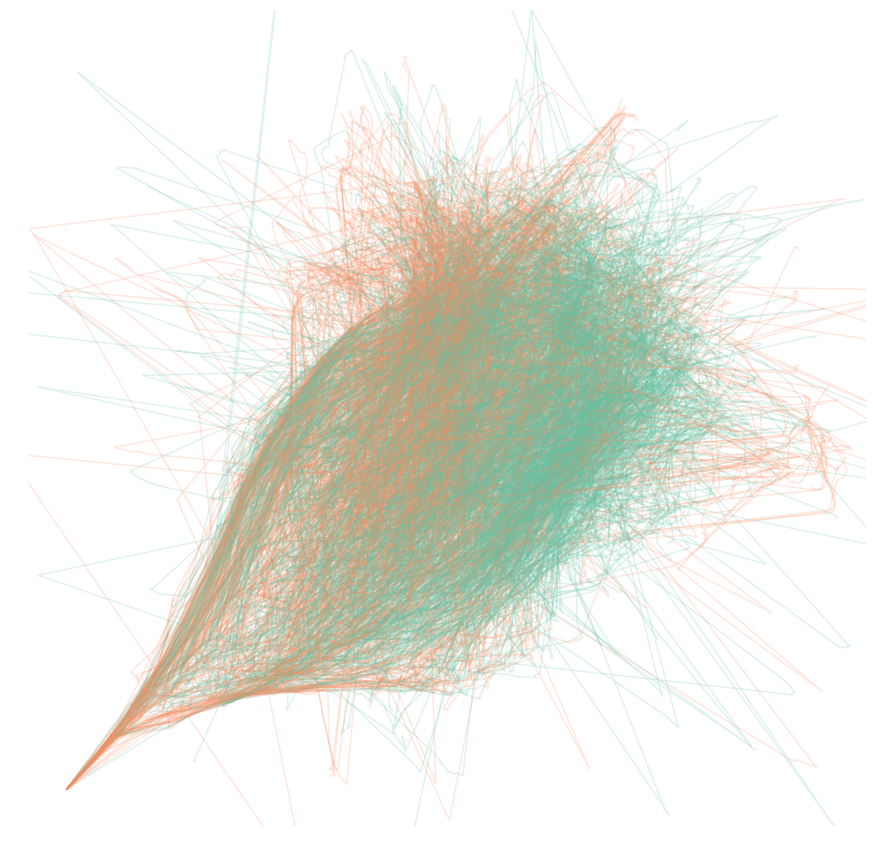

In [147]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
#ax.legend(markers, word_pal.keys(), numpoints=1)

cols = [word_pal[i] for i in words]
for oi, (on, off) in enumerate(tqdm(zip(onsets, offsets), total=len(offsets))):
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.2, color=word_pal[words_df.word.values[oi]])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'words_trajectory', save_png=True)

### plot the average over each vector for word

In [148]:
from scipy.interpolate import interp1d

In [149]:
#fig, ax = plt.subplots(figsize=(5,5))
word_list = []
word_embedding_list = []
for oi, (word, on, off) in enumerate(tqdm(zip(words_df.word, onsets, offsets), total=len(offsets))):

    window_z = embedding[on:off,:]
    
    word_list.append(word)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    word_embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
word_embedding_list = np.array(word_embedding_list)
word_list = np.array(word_list)

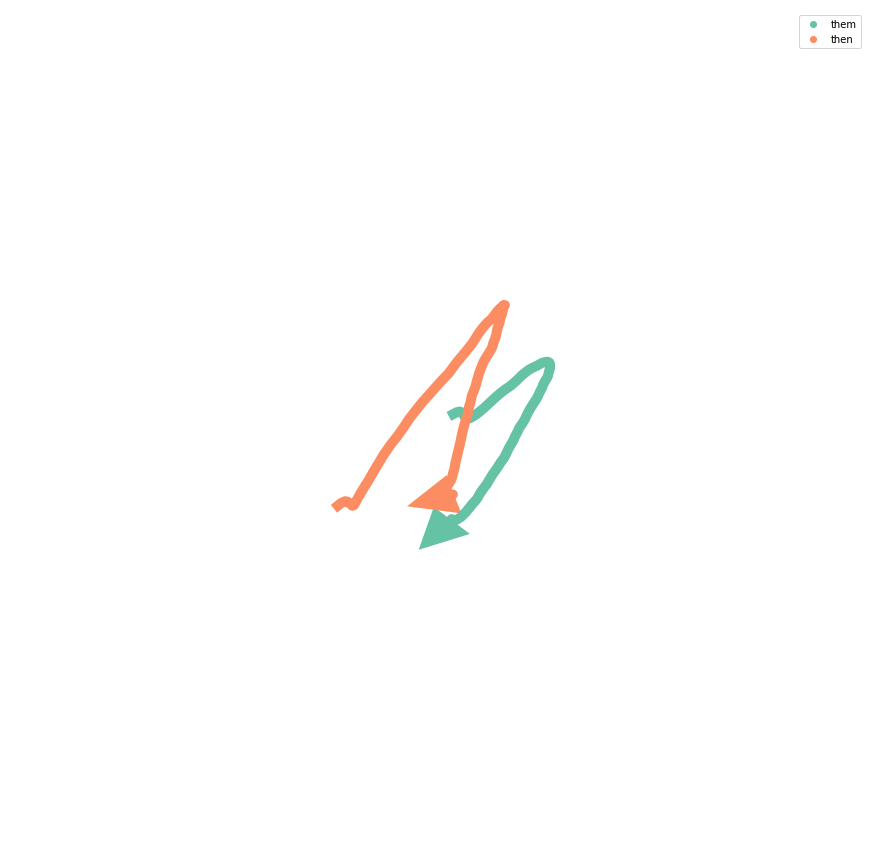

In [150]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)


for word in np.unique(word_list):
    mean_embedding = np.mean(word_embedding_list[word_list == word], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=word_pal[word],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=word_pal[word],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')
if savefig: save_fig(FIG_SAVE_LOC / 'words_vector', save_png=True, save_svg=True)

### color by phonemes

In [151]:
#make a list of phones, onsets, and offsets for each phone
# for each word, for each phone, get start time and end time in frames

In [152]:
window_length_ms = 4
hop_length_ms = 4
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

1

In [153]:
phones = []
phone_onsets = []
phone_offsets = []
words_phones = []
for wdsi, (idx, row) in tqdm(enumerate(words_df.iterrows()), total= len(words_df)):
    cur_windows = len(row.windows)
    phone_start_frame = [0]
    phone_end_frame = []
    for pi, (phone, pst, pet) in enumerate(zip(row.phones, row.phone_start_times, row.phone_end_times)):
        phone_end_frame.append(int(pet / (window_length_ms / 1000)))
        if pi < len(row.phones)-1:
            phone_start_frame.append(phone_end_frame[-1]+1)
    
    phone_onsets.append(np.array(phone_start_frame) + np.sum([0] + n_windows[:wdsi]))
    phone_offsets.append(np.array(phone_end_frame) + np.sum([0] + n_windows[:wdsi]))
    phones.append(row.phones)
    words_phones.append(np.repeat(row.word, len(row.phones)))
phones = np.concatenate(phones)    
phone_onsets = np.concatenate(phone_onsets)
phone_offsets = np.concatenate(phone_offsets)
words_phones = np.concatenate(words_phones)

In [154]:
print(phones[:15], phone_onsets[:15], phone_offsets[:15])

['dh' 'eh' 'm' 'dh' 'eh' 'nx' 'dh' 'eh' 'm' 'dh' 'eh' 'nx' 'dh' 'eh' 'n'] [  0  17  60  85  95 109 112 128 151 182 201 274 281 321 356] [ 16  59  84  94 108 111 127 150 181 200 273 280 320 355 364]


In [155]:
common_phones = pd.DataFrame({i:[sum(phones == i)] for i in np.unique(phones)}).T.sort_values(by=0, ascending=False)[:5].T
common_phones

,eh,dh,m,n,ah
0,927,874,854,537,486


In [156]:
common_phones.columns

Index(['eh', 'dh', 'm', 'n', 'ah'], dtype='object')

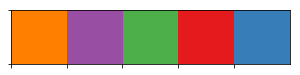

In [157]:
pal = np.random.permutation(sns.color_palette('Set1', len(common_phones.columns)))
sns.palplot(pal)
phone_pal = {word:pal[wordi] for wordi, word in enumerate(common_phones.columns)}

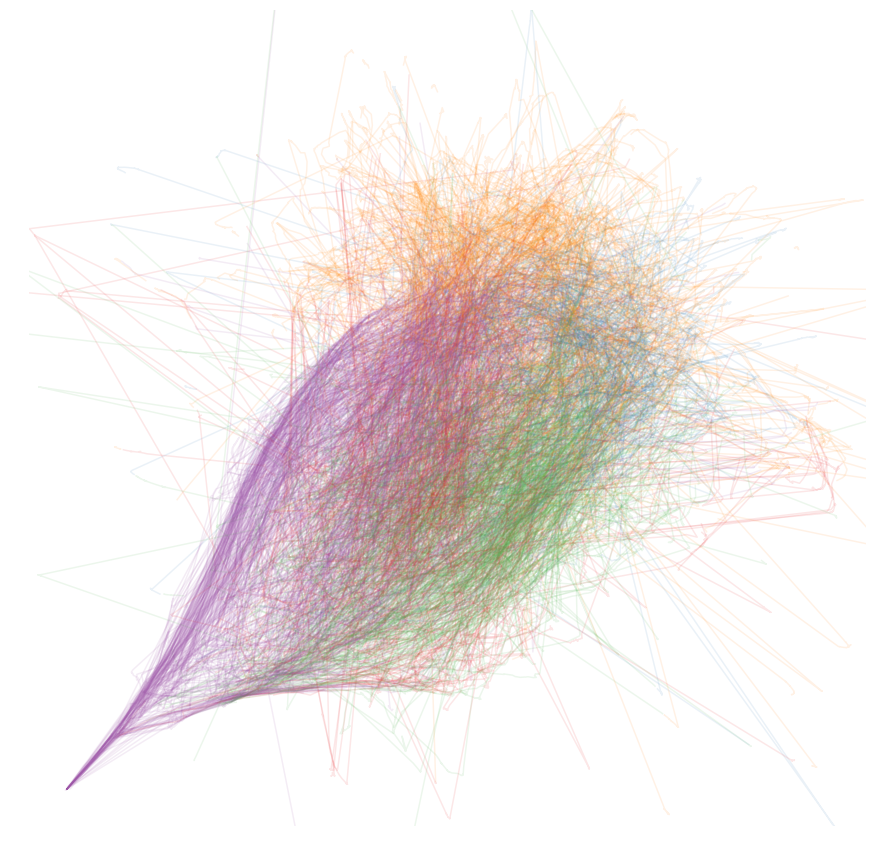

In [158]:
fig, ax = plt.subplots(figsize=(15,15))
#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
#ax.legend(markers, phone_pal.keys(), numpoints=1)

for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color=phone_pal[phone])
    #if oi > 1000:
    #    break
ax.set_xlim(xlims);
ax.set_ylim(ylims);
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_trajectory', save_png=True, save_svg=False)

### plot the average vector for each phone

In [159]:
len(np.linspace(0,1, len(window_z)))

12

In [160]:
np.shape(interp_window_z)

(100, 2)

In [161]:
len(window_z)

12

In [162]:
#fig, ax = plt.subplots(figsize=(5,5))
phone_list = []
embedding_list = []
for oi, (phone, on, off) in enumerate(tqdm(zip(phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    if len(window_z) <2 : continue
    phone_list.append(phone)
    
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
embedding_list = np.array(embedding_list)
phone_list = np.array(phone_list)

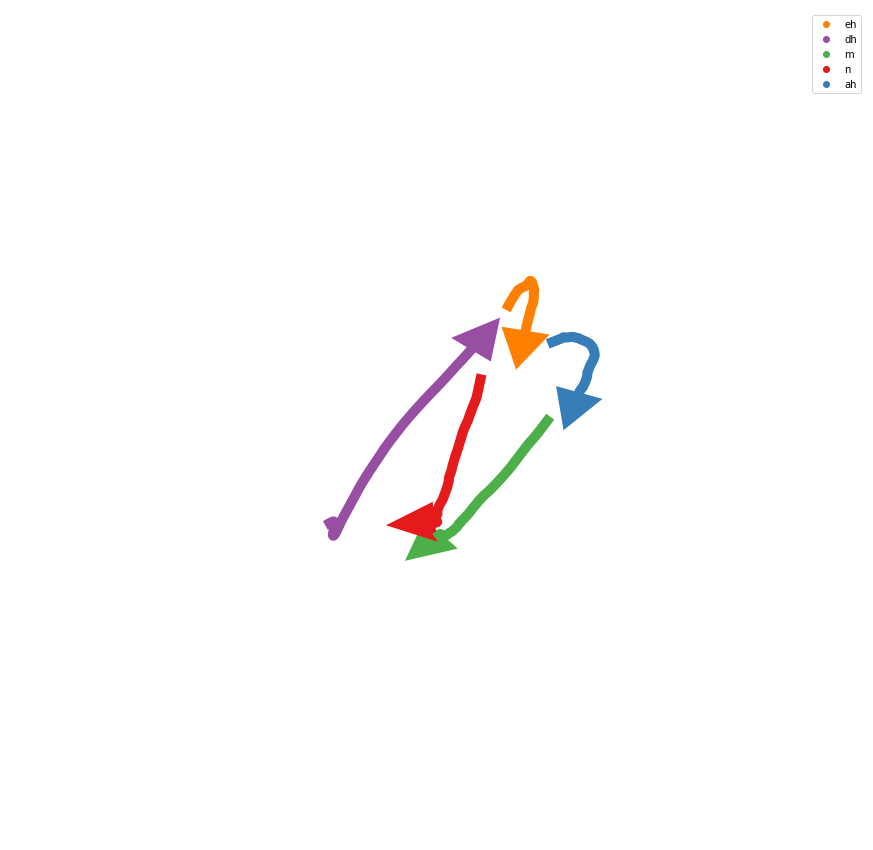

In [163]:
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
ax.legend(markers, phone_pal.keys(), numpoints=1)


for phone in np.unique(phone_list):
    mean_embedding = np.mean(embedding_list[phone_list == phone], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=phone_pal[phone],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=phone_pal[phone],
        length_includes_head=False,
    )

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_vector', save_png=True, save_svg=True)

### plot phone by context

In [164]:
#fig, ax = plt.subplots(figsize=(5,5))
word_list = []
phone_list = []
embedding_list = []
for oi, (wp, phone, on, off) in enumerate(tqdm(zip(words_phones, phones, phone_onsets, phone_offsets), total=len(phone_offsets))):
    if phone not in common_phones.columns:
        continue
    window_z = embedding[on:off,:]
    
    phone_list.append(phone)
    word_list.append(wp)
    f1 = interp1d(np.linspace(0,1, len(window_z)), window_z.T, kind='linear')
    interp_window_z = f1(np.linspace(0,1, 100)).T
    
    embedding_list.append(interp_window_z)
    
    #ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
    #ax.scatter(interp_window_z[:,0], interp_window_z[:,1], alpha = 1, s = 25, color=phone_pal[phone])
embedding_list = np.array(embedding_list)
phone_list = np.array(phone_list)
word_list = np.array(word_list)

In [182]:
savefig = True

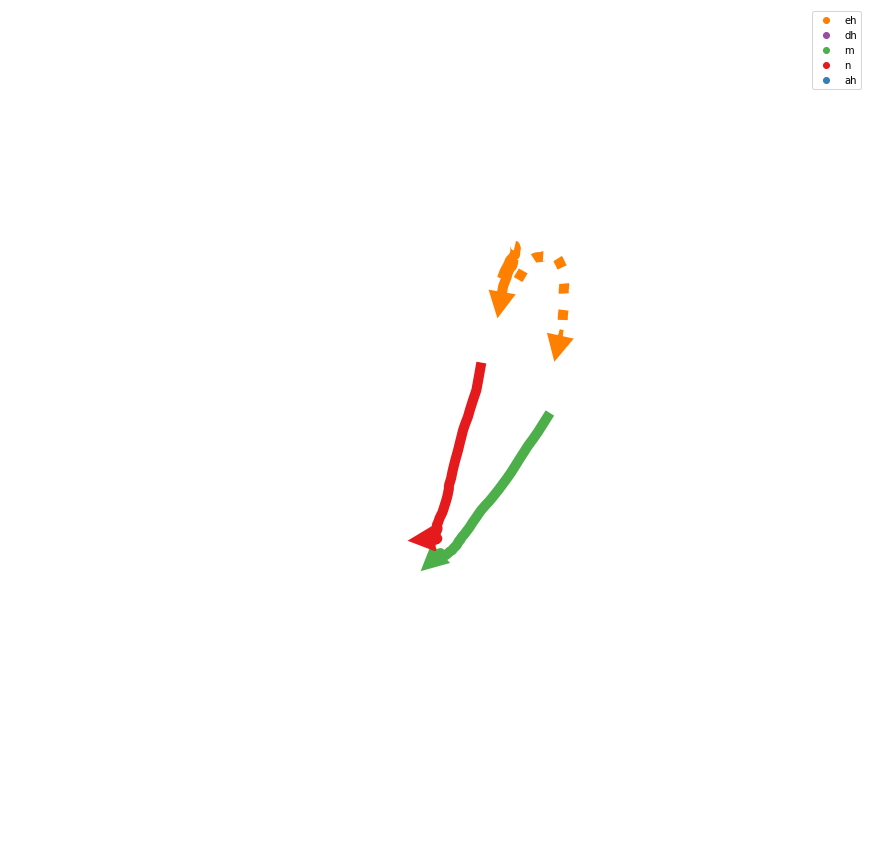

In [188]:
phone_of_interest = 'eh'
fig, ax = plt.subplots(figsize=(15, 15))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in phone_pal.values()]
ax.legend(markers, phone_pal.keys(), numpoints=1)


for phone in np.unique(phone_list):
    if phone not in ['n', 'm']:
        continue
    if phone == phone_of_interest:
        continue
    mean_embedding = np.mean(embedding_list[phone_list == phone], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=6,
        color=phone_pal[phone],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.25,
        head_length=.25,
        linewidth=4,
        color=phone_pal[phone],
        length_includes_head=False,
    )


for word in np.unique(word_list):
    mean_embedding = np.mean(embedding_list[(word_list == word) & (phone_list == phone_of_interest)], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=6,
        ls={"then":'dashed', "them":"dotted"}[word],
        color=phone_pal[phone_of_interest],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-1, 0] - mean_embedding[-2, 0],
        mean_embedding[-1, 1] - mean_embedding[-2, 1],
        head_width=.25,
        head_length=.25,
        linewidth=4,
        color=phone_pal[phone_of_interest],#word_pal[word],
        length_includes_head=False,
    )

"""phone_of_interest = 'k'
for word in np.unique(word_list):
    mean_embedding = np.mean(embedding_list[(word_list == word) & (phone_list == phone_of_interest)], axis=0)
    ax.plot(
        mean_embedding[:, 0],
        mean_embedding[:, 1],
        alpha=1,
        lw=10,
        color=word_pal[word],
    )
    ax.arrow(
        mean_embedding[-2, 0],
        mean_embedding[-2, 1],
        #mean_embedding[-1, 0] - mean_embedding[-2, 0],
        #mean_embedding[-1, 1] - mean_embedding[-2, 1],
        mean_embedding[-5, 0] - mean_embedding[-10, 0],
        mean_embedding[-5, 1] - mean_embedding[-10, 1],
        head_width=.5,
        head_length=.5,
        linewidth=4,
        color=word_pal[word],
        length_includes_head=False,
    )"""

    
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

if savefig: save_fig(FIG_SAVE_LOC / 'phones_vector', save_png=True, save_svg=True)

### spectrograms vs embeddings in colorspace

In [166]:
# plot segment labels alongside phone labels

In [167]:
import copy

In [168]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

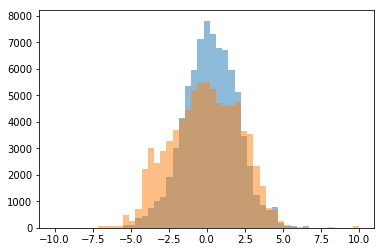

In [169]:
z_normed = copy.deepcopy(embedding)
plt.hist(z_normed[:,0], bins = np.linspace(-10,10, 50), alpha = 0.5);
plt.hist(z_normed[:,1], bins = np.linspace(-10,10, 50), alpha = 0.5);

In [170]:
xlims = [-5,5]
ylims = [-5,5]

In [171]:
z_normed[:,0][z_normed[:,0] > xlims[1]] = xlims[1]
z_normed[:,0][z_normed[:,0] < xlims[0]] = xlims[0]
z_normed[:,1][z_normed[:,1] > ylims[1]] = ylims[1]
z_normed[:,1][z_normed[:,1] < ylims[0]] = ylims[0]

z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [172]:
window_z = z_normed
R = 1-norm(window_z[:,0])#*.75 + .25
G = 1-norm(window_z[:,1])#*.75 + .25
B = np.ones_like(G)*.5
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [173]:
phone_pal

{'eh': array([1.        , 0.49803922, 0.        ]),
 'dh': array([0.59607843, 0.30588235, 0.63921569]),
 'm': array([0.30196078, 0.68627451, 0.29019608]),
 'n': array([0.89411765, 0.10196078, 0.10980392]),
 'ah': array([0.21568627, 0.49411765, 0.72156863])}

In [174]:
np.shape(rgb_img)

(1, 80907, 3)

In [175]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

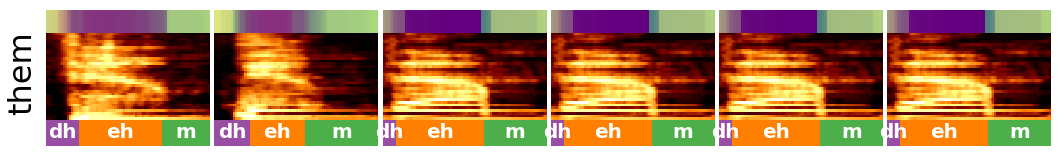

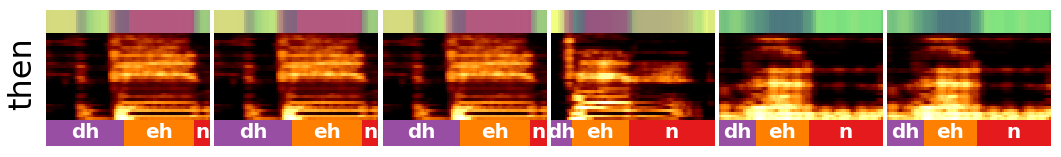

In [184]:
ncols = 6
for wi, word in enumerate(words_df.word.unique()):
    
    fig = plt.figure(figsize=((ncols)*3, 2.5)) 
    gs = gridspec.GridSpec(2, ncols, height_ratios=[1, 5]) 
    gs.update(wspace=0.025, hspace=0)
    
    for ci,col in enumerate(range(ncols)):
       
    
        row = words_df[words_df.word == word].iloc[col]
        
        while np.all([i in phone_pal for i in row.phones]) == False:
            col = col + 1
            row = words_df[words_df.word == word].iloc[col]
        
        ### plot projections
        ax = plt.subplot(gs[0, ci]) #axs[col]
        # subset embedding 
        on = onsets[np.where(words_df.index == row.name)[0][0]]
        off = offsets[np.where(words_df.index == row.name)[0][0]]

        ax.imshow(rgb_img[:,on:off, :], aspect='auto')
        
        ax.axis('off')
        ### plot spec
        ax = plt.subplot(gs[1, ci]) #axs[col]
        if ci == 0: 
            ax.set_ylabel(word, fontsize=32)
            ax.yaxis.set_label_coords(-0.05,.65)
        spec = row.spectrogram
        ax.matshow(spec, aspect='auto', origin='lower', extent = [0, row.end_time - row.start_time, 0,1], cmap = plt.cm.afmhot)
        ax.set_ylim([-.3,1])
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        for phone, st, et in zip(row.phones, row.phone_start_times, row.phone_end_times):
            
            ax.add_patch(
            mpatches.Rectangle(
                [st, -.3],
                et - st,
                .3,
                ec="none",
                color=phone_pal[phone],
            )
            )
            ax.text((st + et)/2, -.2, phone, color='w', fontsize=20, horizontalalignment='center', weight='bold')
            
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.axis('off')
    if savefig: save_fig(FIG_SAVE_LOC / ('spec_' + word), save_png=True, save_svg=True)
    plt.show()

In [177]:
row

start_time                                                         185.603
end_time                                                           185.968
word                                                                  then
phones                                                         [dh, eh, n]
phone_start_times         [0.0, 0.047762000000005855, 0.17424200000002088]
phone_end_times          [0.047762000000005855, 0.17424200000002088, 0....
utterance_number                                                        57
position_in_utterance                                                   20
word_number                                                             20
indv                                                                   s08
indvi                                                                    0
age                                                                      y
sex                                                                      f
key                      